# Count cars in aerial imagery using deep learning

## Table of Contents
* [Introduction](#Introduction)
* [Necessary imports](#Necessary-imports)
* [Connect to your GIS](#Connect-to-your-GIS)
* [Get data and model for analysis](#Get-data-and-model-for-analysis)
* [Detect and count cars](#Detect-and-count-cars)
* [Visualize detections on map](#Visualize-detections-on-map)
* [Conclusion](#Conclusion)
* [References](#References)

## Introduction 

ArcGIS pretrained models automate the task of digitizing and extracting geographical features from imagery and point cloud datasets. Manually extracting features from raw data, such as digitizing cars, is time consuming. Deep learning automates the process and minimizes the manual interaction necessary to complete these tasks. However, training a deep learning model can be complicated as it needs large amounts of data, computing resources, and knowledge of how deep learning works.

With ArcGIS pretrained models, we do not need to invest time and energy into training a deep learning model. The ArcGIS models have been trained on data from a variety of geographies and work well across them. These pretrained models are available on [ArcGIS Living Atlas of the World](https://livingatlas.arcgis.com/en/home/) to anyone with an ArcGIS account.

[Car Detection-USA](https://doc.arcgis.com/en/pretrained-models/latest/imagery/introduction-to-car-detection-usa.htm) is used to detect cars in high-resolution drone or aerial imagery. Car detection can be used for applications such as traffic management and analysis, parking lot utilization, urban planning, and more. It can also be used as a proxy for deriving economic indicators and estimating retail sales. High-resolution aerial and drone imagery can be used for car detection due to its high spatiotemporal coverage.

## Necessary imports

In [1]:
import arcgis
from arcgis.gis import GIS
from arcgis.learn import detect_objects
from arcgis.raster.functions import equal_to

import pandas as pd
from datetime import datetime as dt
from ipywidgets import HBox, VBox, Label, Layout

## Connect to your GIS

In [2]:
gis = GIS('home')

First, search for your imagery layer in ArcGIS Online. We can search for content shared by users outside our organization by setting `outside_org` to True.

## Get data and model for analysis

We have downloaded aerial imagery from [OpenAerialMap](https://openaerialmap.org/) and published it as a dynamic imagery layer, allowing us to get it below.

We will use three items for our analysis. We can get the uploaded imageries using their item id.

In [3]:
site_1 = gis.content.get('3409a289b12740c1a8cd0aea6a6da409')
site_2 = gis.content.get('29ddf4b2463c4a77a79197d6d2f97801')
site_3 = gis.content.get('84ca1eb102164e1c9d2208dc4efdce6e')

To count the detected cars in multiple imageries, create a list of imageries.

In [4]:
imagery_list = [site_1, site_2, site_3]

Visualize the imagery using layers attribute and indexing.

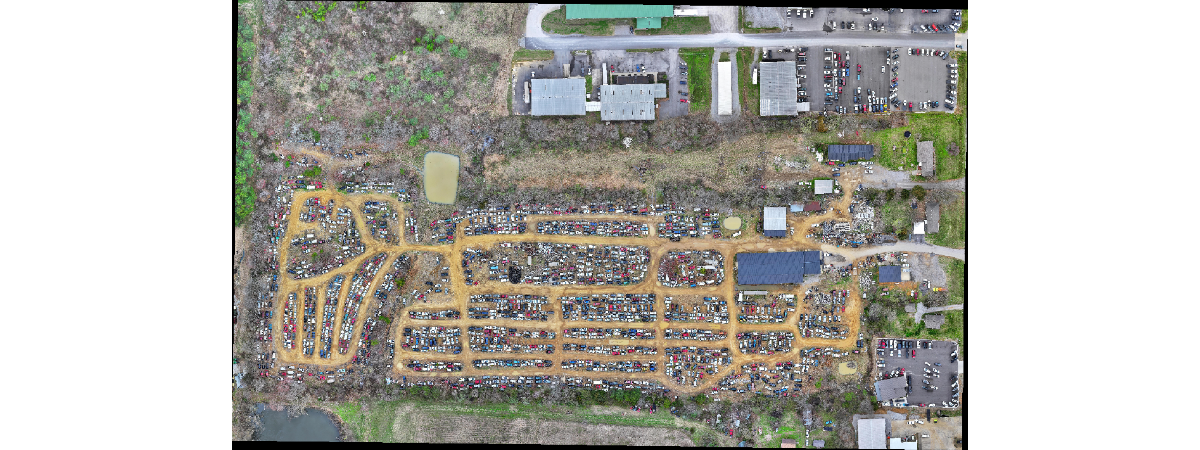

In [5]:
imagery_list[2].layers[0]

Search for the pretrained model item in `ArcGIS Living Atlas of the World`. 

<Item title:"Car Detection - USA" type:Deep Learning Package owner:esri_analytics>
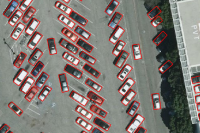

In [6]:
model = gis.content.search(
    "Car Detection-USA owner: esri_analytics", "Deep Learning Package", outside_org=True
)[0]
model

## Detect and count cars

The following code runs `detect_objects` function over each imagery and calculates the total count of cars detected. It then stores the item name and and its cars count in a dictionary named `num_cars`.

Create a dictionary `num_cars` to save the number of cars detected in each imagery.

In [7]:
num_cars = {}

Create a for loop to iterate through each imagery.

In [8]:
for i in range(len(imagery_list)):
    
    # Get the imagery using indexing
    raster = imagery_list[i].layers[0]
    
    # Call the function detect_objects and assign values to its parameters
    detected_cars = detect_objects (
        
        # The input image used to detect objects.
        input_raster = raster,
        
        # The deep learning model to use to detect objects. 
        model = model,
        
        # The output detected features file name.
        output_name = "detected_cars" + str(dt.now().microsecond),
        
        # The name value pairs of arguments and their values that can be customized by the clients.
        model_arguments = {
            "padding": "100",
            "batch_size": "16",  # Change batch size as per GPU specifications
            "threshold": "0.9",  # Get detections greater than 90% confidence
            "return_bboxes": "False",
            "tile_size": "224",
        },
        
        # Context allows to set environment settings that affect task operation. 
        context = {   
            "processorType": "GPU" # The specified processor (CPU or GPU) will be used for the analysis.
        }
    )
    
    # Save the number of cars detected in an imagery with its file name before iterating to next imagery. 
    num_cars[imagery_list[i].name] = len(detected_cars.query(as_df=True))

## Visualize detections on map

Let's visualize the detected cars in one of the aerial images. 

In [9]:
# Create a map object
map1 = gis.map()

# Add input imagery to map object
map1.content.add(imagery_list[2])

# Create another map object to see the detected features simultaneously
map2 = gis.map()

# Add both input imagery and detected features to second map object
map2.content.add(imagery_list[2])
map2.content.add(detected_cars)

Sync both the maps.

In [10]:
map1.sync_navigation(map2)

Create layout to visualize both the map objects. Keep running the below cells. Maps will automatically update here.

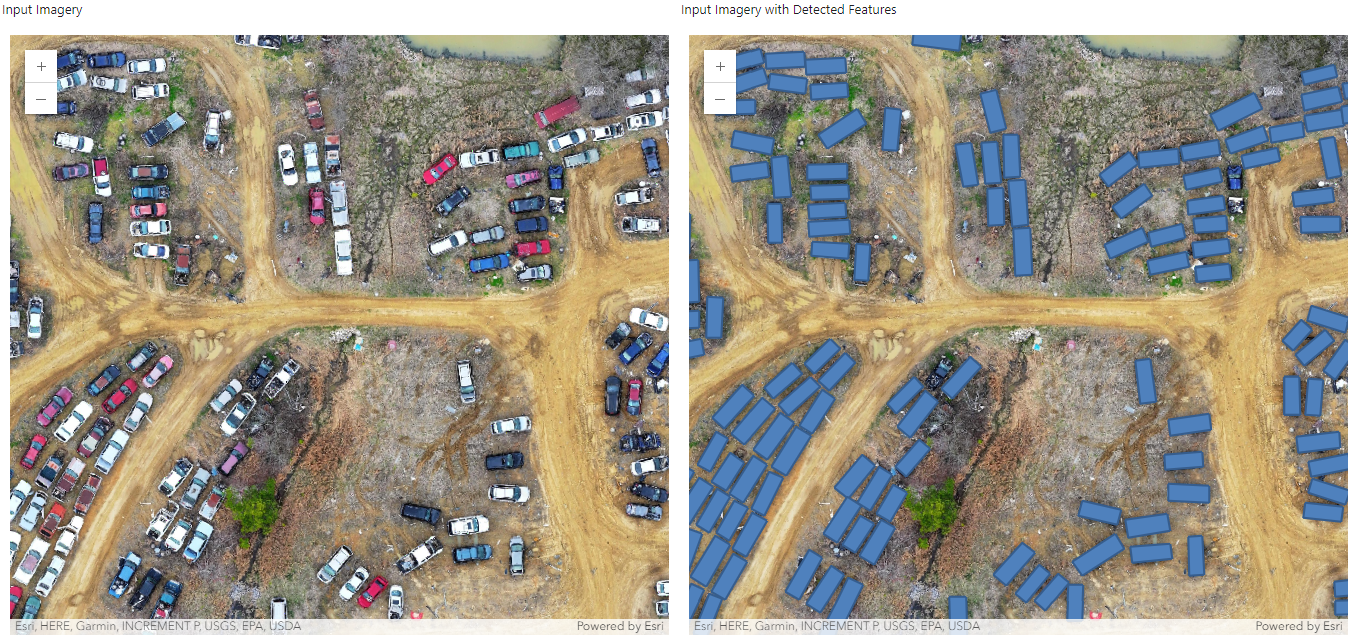

In [11]:
from ipywidgets import *

map1.layout = Layout(flex = '1 1', padding = '10px')
map2.layout = Layout(flex = '1 1', padding = '10px')

# Create VBoxes for each map and label
box1 = VBox([Label("Input Imagery"), map1], layout=Layout(width='50%'))
box2 = VBox([Label("Input Imagery with Detected Features"), map2], layout=Layout(width='50%'))

# Place the VBoxes side by side using an HBox
hbox = HBox([box1, box2])

# Display the HBox
hbox

Zoom to the extent of detected features using `zoom_to_layer` attribute

In [12]:
map1.zoom_to_layer(detected_cars)

Set the extent of the map to your desired extent.

In [13]:
map1.extent = {'spatialReference': {'latestWkid': 3857, 'wkid': 102100},
 'xmin': -9868335.395370293,
 'ymin': 4407583.248035807,
 'xmax': -9868237.01255462,
 'ymax': 4407672.8226783015}

Now you must be seeing the added imagery layer and detected features over the map in the desired extent.

Check the count of cars in each imagery by displaying the output of `num_cars` dictionary created in above steps.

In [14]:
num_cars  # shows number of cars detected in each imagery layer.

{'car_image1': 780, 'car_image_2': 83, 'car_image_3': 1744}

## Conclusion

This sample demonstrated how Car Detection-USA pretrained model can be used to detect cars in an aerial imagery and get the cars count in an area. 

## References

- Imagery from [OpenAerialMap](https://openaerialmap.org/) is licensed under [CC-BY 4.0](https://creativecommons.org/licenses/by/4.0/)